In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
from scipy.optimize import minimize
from tqdm import tqdm

In [2]:
def MPC(setpoint):

    ns = 300
    K = 2
    taus = 1.1
    thetap = 0.0  # (Delay)
    zeta = 2.0

    t = np.linspace(0,ns,ns+1)
    delta_t = t[1]-t[0]

    # Define horizons
    P = 20 # Prediction Horizon
    M = 5  # Control Horizon

    # Input Sequence
    u = np.zeros(ns+1)

    # Setpoint Sequence
    sp = np.zeros(ns+1+2*P)
    sp[0:len(setpoint)] = setpoint
    sp[len(setpoint):] = setpoint[-1]

    # Controller setting
    maxmove = 100

    def process_model(x,t,u,Kp,taus,zeta):
        # Kp = process gain
        # taus = second order time constant
        # zeta = damping factor
        # ts^2 dy2/dt2 + 2 zeta taus dydt + y = Kp u(t-thetap)
        y = x[0]
        dydt = x[1]
        dy2dt2 = (-2.0*zeta*taus*dydt - y + Kp*u)/taus**2
        return [dydt,dy2dt2]
    
    # Define Objective function      
    def objective(u_hat):
        # Prediction
        for k in range(1,2*P+1):
            if k==1:
                y_hat0 = yp[i-P]

            if k<=P:
                if i-P+k<0:
                    u_hat[k] = 0
                else:
                    u_hat[k] = u[i-P+k]

            elif k>P+M:
                u_hat[k] = u_hat[P+M]

            ts_hat = [delta_t_hat*(k-1),delta_t_hat*(k)]        
            y_hat = odeint(process_model,y_hat0,ts_hat,args=(u_hat[k],K,taus,zeta))
            
            y_hat0 = y_hat[-1]
            yp_hat[k] = y_hat[0][0]

            # Squared Error calculation
            sp_hat[k] = sp[i]
            delta_u_hat = np.zeros(2*P+1)        

            if k>P:
                delta_u_hat[k] = u_hat[k]-u_hat[k-1]
                se[k] = (sp_hat[k]-yp_hat[k])**2 + 20 * (delta_u_hat[k])**2

        # Sum of Squared Error calculation      
        obj = np.sum(se[P+1:])
        return obj

    ## Process simulation
    yp = np.zeros((ns+1,2))

    for i in tqdm(range(1,ns+1)):
        if i==1:
            y0 = np.array([0,0])
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process_model,y0,ts,args=(u[int(max(0,i-thetap))],K,taus,zeta))
        y0 = y[-1]
        yp[i] = y[0]

        # Declare the variables in fuctions
        t_hat = np.linspace(i-P,i+P,2*P+1)
        delta_t_hat = t_hat[1]-t_hat[0]
        se = np.zeros(2*P+1)
        yp_hat = np.zeros(2*P+1)
        u_hat0 = np.zeros(2*P+1)
        sp_hat = np.zeros(2*P+1)
        obj = 0.0

        # initial guesses
        for k in range(1,2*P+1):
            if k<=P:
                if i-P+k<0:
                    u_hat0[k] = 0
                else:
                    u_hat0[k] = u[i-P+k]
            elif k>P:
                u_hat0[k] = u[i]
 
        solution = minimize(objective,u_hat0,method='SLSQP')
        u_hat = solution.x  
 
        delta = np.diff(u_hat)

        if i<ns:    
            if np.abs(delta[P]) >= maxmove:
                if delta[P] > 0:
                    u[i+1] = u[i]+maxmove
                else:
                    u[i+1] = u[i]-maxmove

            else:
                u[i+1] = u[i]+delta[P]
      
    return (yp[:,0])  

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces, logger
from gym.utils import seeding
from scipy.integrate import odeint
from tqdm import tqdm
import os
import torch.nn as nn
import torch as T
import torch.nn.functional as F
import torch.optim as optim

class Agent():
    def __init__(self, alpha, beta, input_dims, tau, n_actions, gamma=0.99,
                 max_size=100000, fc1_dims=400, fc2_dims=300, 
                 batch_size=128):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='actor')
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='critic')

        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_actor')

        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(), 
                                    dtype=T.float).to(self.actor.device)
        self.actor.train()

        return mu_prime.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, done = \
                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
             actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                 (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        #self.target_critic.load_state_dict(critic_state_dict, strict=False)
        #self.target_actor.load_state_dict(actor_state_dict, strict=False)

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='content/tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        
        self.q = nn.Linear(self.fc2_dims, 1)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1./np.sqrt(self.action_value.weight.data.size()[0])
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        #state_value = F.relu(state_value)
        #action_value = F.relu(self.action_value(action))
        action_value = self.action_value(action)
        state_action_value = F.relu(T.add(state_value, action_value))
        #state_action_value = T.add(state_value, action_value)
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='content/tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #x = T.tanh(self.mu(x))
        x = self.mu(x)
        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [4]:
class Process(gym.Env):
    def __init__(self, n_yt, n_ut, n_rew, zeta, setpoint):
      self.Kp = 2.0
      self.taup = 1.0
      self.zeta = zeta
      self.delta_t = 0.1
      self.delay = 0
      self.steps = 0
      self.count = 0
      self.n_yt = n_yt
      self.n_ut = n_ut
      self.n_rew = n_rew
      self.eps = 1e-5

      dim = self.n_yt+self.n_ut+self.n_rew
      self.dim = dim
      self.setpoint = np.array(setpoint)
      self.state = np.array([0]*dim, dtype=np.float32)

      state_high = np.array([100.0]*dim, dtype=np.float)
      state_low = np.array([0.0]*dim, dtype=np.float)
      action_high = np.array([100.0], dtype=np.float)
      action_low = np.array([0.0], dtype=np.float)

      self.observation_space = spaces.Box(state_low, state_high, dtype=np.float32)
      self.action_space = spaces.Box(action_low, action_high, dtype=np.float32)


    def process(self,y,t,action):
      # Kp = process gain
      # taup = process time constant
        dydt = -y/self.taup + self.Kp*action/self.taup
        return dydt

    def step(self, act):
      st_2, st_1, st_0, _ = self.state[0], self.state[1:self.n_yt-1], self.state[self.n_yt-1], self.state[self.n_yt:]
      # print(act[-1])
      # st__1 = act[-1]*self.Kp*(1-np.exp(-self.zeta*0.1*self.steps/self.taup)*(np.cosh(0.1*self.steps/self.taup*(np.sqrt(self.zeta**2-1))))+self.zeta/np.sqrt(self.zeta**2-1)*np.sinh(0.1*self.steps/self.taup*(np.sqrt(self.zeta**2-1))))
      if self.zeta==1:
        if self.steps>=self.delay:
          st__1 = self.Kp*act[-1]*(1-(1+(self.steps-self.delay)/self.taup)*np.exp(-(self.steps-self.delay)/self.taup))
        else:
          st__1 = 0
      elif self.zeta<1:
        if self.steps>=self.delay:
          st__1 = self.Kp*act[-1]*(1-np.exp(-self.zeta*(self.steps-self.delay)/self.taup)*(np.cos((self.steps-self.delay)*np.sqrt(1-self.zeta*self.zeta)/self.taup)+np.sin((self.steps-self.delay)*np.sqrt(1-self.zeta*self.zeta)/self.taup)*self.zeta/np.sqrt(1-self.zeta*self.zeta)))
        else:
          st__1 = 0
      else:
        if self.steps>=self.delay:
          st__1 = self.Kp*act[-1]*(1-np.exp(-self.zeta*(self.steps-self.delay)/self.taup)*(np.cosh((self.steps-self.delay)*np.sqrt(-1+self.zeta*self.zeta)/self.taup)+np.sinh((self.steps-self.delay)*np.sqrt(-1+self.zeta*self.zeta)/self.taup)*self.zeta/np.sqrt(-1+self.zeta*self.zeta)))
        else:
          st__1 = 0
      self.steps+=1
      reward = -np.abs(st__1-self.setpoint[self.steps-1])
      st_1 = np.append(st_1, [st_0, st__1])
      st_1 = np.append(st_1, [act])
      self.state = np.append(st_1, [reward])
      done = bool(self.steps>=300)

      return (self.state, reward, done, {})

    def reset(self):
      self.state = [0]*self.dim
      self.steps = 0
      self.count = 0
      return np.array(self.state)

In [5]:
def DRL(setpoint, zeta):

    n_yt = 2
    n_ut = 1
    n_prev_reward = 1
    env = Process(n_yt,n_ut,n_prev_reward, zeta, setpoint)
    n_games = 100
    fc1_dims = 400
    fc2_dims = 300
    agent = Agent(alpha=0.001, beta=0.001, input_dims = env.observation_space.shape, tau = 0.01, batch_size = 128, n_actions = env.action_space.shape[0], fc1_dims = 400 , fc2_dims = 300)
    f_name = 'SISO_alpha' + str(agent.alpha) + 'beta_' + str(agent.beta) + '_' + str(n_games) + '_' + 'Episodes' + 'fc1_dims_' + str(fc1_dims) + '_' + 'fc2_dims_' + str(fc2_dims) 
    figure_file = 'plots/' + f_name + '.png'

    best_score = env.reward_range[0]
    scores = []
    Actions = []
    Observations = []
    best = 0
    for i in tqdm(range(n_games)):
        obs = env.reset()
        act = [0]*n_ut
        prev_reward = [0]*n_prev_reward
        score = 0
        done = False
        agent.noise.reset()
        Action = []
        Observation = []
        while not done:
          action = agent.choose_action(obs)
          if act: act.pop(0)
          act.append(action[0])
          Action.append(action[0])
          
          Observation.append(obs[n_yt-1])
          obs_, reward, done, info = env.step(act)

          prev_reward.pop(0)
          prev_reward.append(reward)

          agent.remember(obs, action, reward, obs_, done)
          score += reward
          agent.learn()
          obs = obs_
        
        scores.append(score)
        avg_score = np.mean(scores[-10:])
        
        if avg_score>best_score:
            best_score = avg_score
            best = i
            # agent.save_models()
        Actions.append(Action)
        Observations.append(Observation) 
         
    return (Observations[best])  

In [6]:
def Plots(setpoint, count):

    print("Overdamped")
    # y1 = results[count]
    # count+=1
    # y1 = PID(setpoint)
    y2 = MPC(setpoint)
    y3 = DRL(setpoint,2)

    plt.figure(figsize=(15,5))
    plt.plot(setpoint)
    # plt.plot(y1[1:], label='PID')
    plt.plot(y2[1:], label='MPC')
    plt.plot(y3, label='DRL')
    plt.legend()
    plt.show()

    # print("PID:{}".format(sum(np.abs(setpoint-y1[1:]))))
    print("MPC:{}".format(sum(np.abs(setpoint-y2[1:]))))
    print("DRL:{}".format(sum(np.abs(setpoint-np.array(y3)))))
    print("\n")

    print("Critically Damped")
    # y1 = PID(setpoint)
    # y1 = results[count]
    # count+=1
    y2 = MPC(setpoint)
    y3 = DRL(setpoint,1)

    plt.figure(figsize=(15,5))
    plt.plot(setpoint)
    # plt.plot(y1[1:], label='PID')
    plt.plot(y2[1:], label='MPC')
    plt.plot(y3, label='DRL')
    plt.legend()
    plt.show()

    # print("PID:{}".format(sum(np.abs(setpoint-y1[1:]))))
    print("MPC:{}".format(sum(np.abs(setpoint-y2[1:]))))
    print("DRL:{}".format(sum(np.abs(setpoint-np.array(y3)))))
    print("\n")

    print("Underdamped")
    # y1 = PID(setpoint)
    # y1 = results[count]
    # count+=1
    y2 = MPC(setpoint)
    y3 = DRL(setpoint,0.5)

    plt.figure(figsize=(15,5))
    plt.plot(setpoint)
    # plt.plot(y1[1:], label='PID')
    plt.plot(y2[1:], label='MPC')
    plt.plot(y3, label='DRL')
    plt.legend()
    plt.show()

    # print("PID:{}".format(sum(np.abs(setpoint-y1[1:]))))
    print("MPC:{}".format(sum(np.abs(setpoint-y2[1:]))))
    print("DRL:{}".format(sum(np.abs(setpoint-np.array(y3)))))
    print("\n")

  0%|          | 0/300 [00:00<?, ?it/s]

Overdamped


100%|██████████| 300/300 [02:03<00:00,  2.43it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:42<00:00,  3.43s/it]


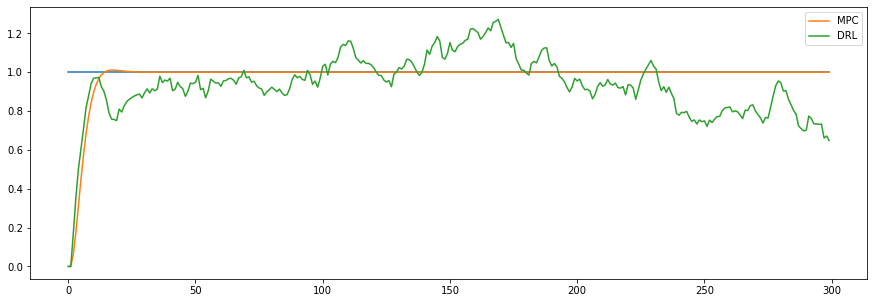

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:6.434403984790797
DRL:37.71860509727178


Critically Damped


100%|██████████| 300/300 [02:01<00:00,  2.48it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:41<00:00,  3.41s/it]


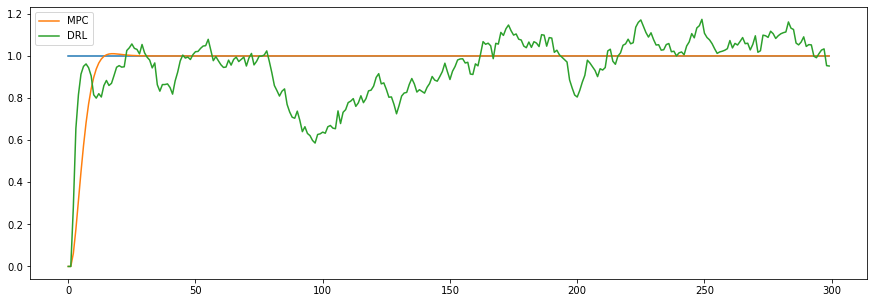

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:6.434403984790797
DRL:32.89206470793681


Underdamped


100%|██████████| 300/300 [02:00<00:00,  2.49it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:42<00:00,  3.42s/it]


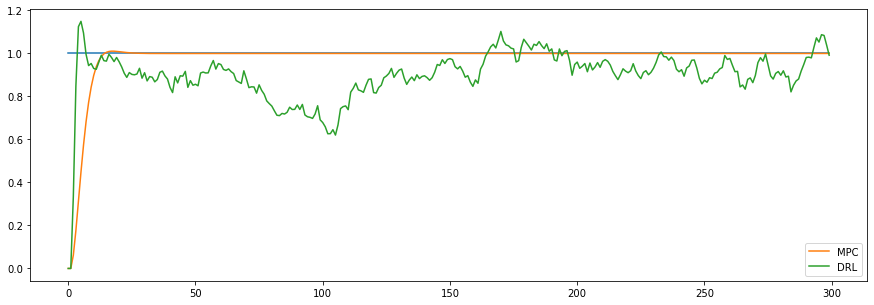

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:6.434403984790797
DRL:33.77052693218034


Overdamped


100%|██████████| 300/300 [02:24<00:00,  2.07it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:42<00:00,  3.43s/it]


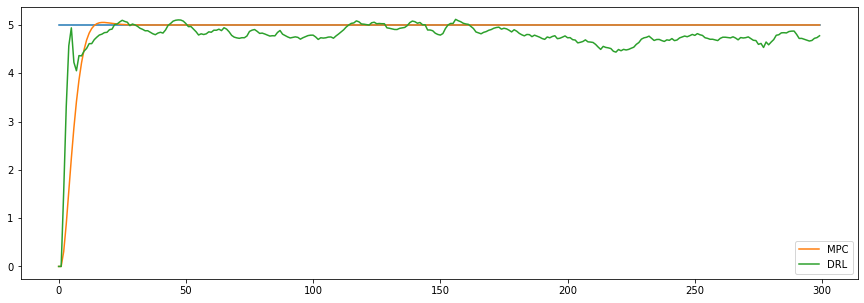

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:32.13743056100755
DRL:77.10763911459617


Critically Damped


100%|██████████| 300/300 [02:26<00:00,  2.05it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:43<00:00,  3.44s/it]


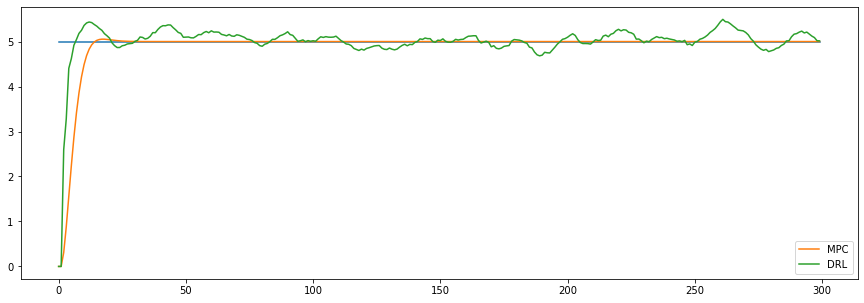

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:32.13743056100755
DRL:52.04575807743707


Underdamped


100%|██████████| 300/300 [02:25<00:00,  2.06it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:44<00:00,  3.45s/it]


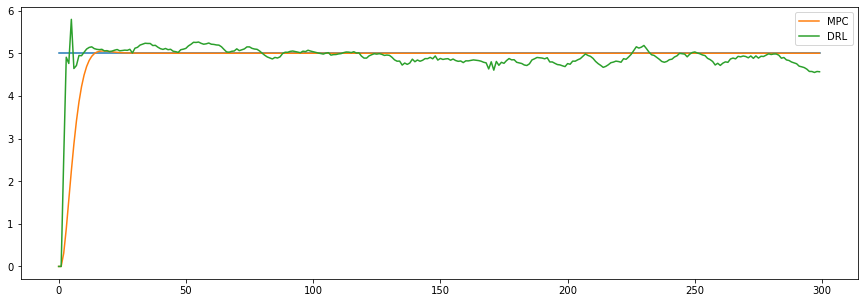

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:32.13743056100755
DRL:53.008161414977764


Overdamped


100%|██████████| 300/300 [02:34<00:00,  1.94it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:46<00:00,  3.46s/it]


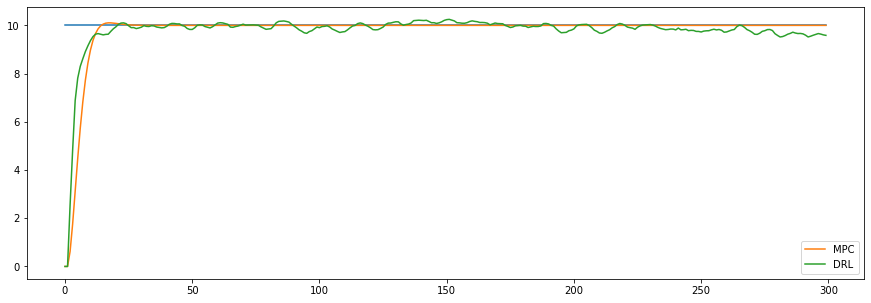

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:64.26246840837159
DRL:85.47190526330931


Critically Damped


100%|██████████| 300/300 [02:33<00:00,  1.95it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:45<00:00,  3.46s/it]


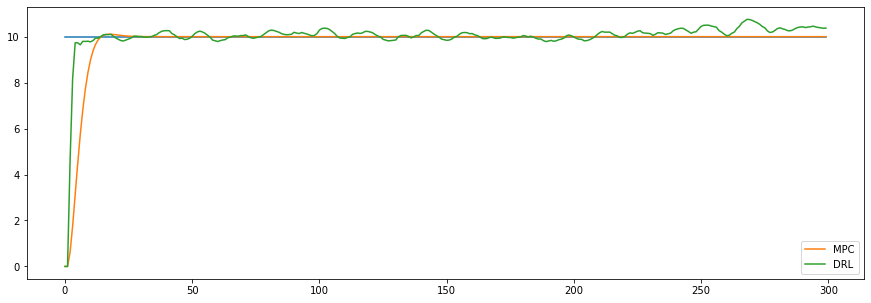

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:64.26246840837159
DRL:76.86440227938739


Underdamped


100%|██████████| 300/300 [02:34<00:00,  1.94it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:45<00:00,  3.46s/it]


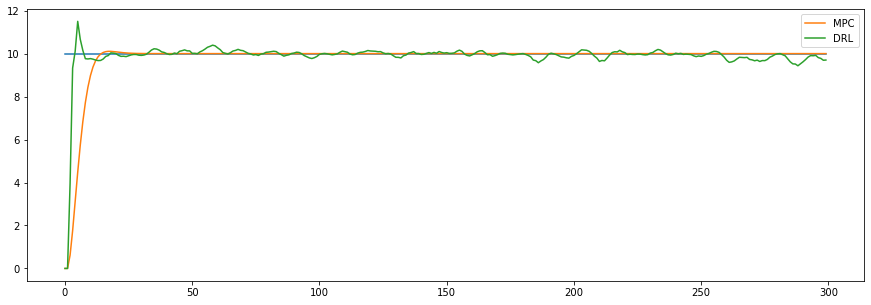

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:64.26246840837159
DRL:63.14412630117689


Overdamped


100%|██████████| 300/300 [03:10<00:00,  1.58it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:47<00:00,  3.47s/it]


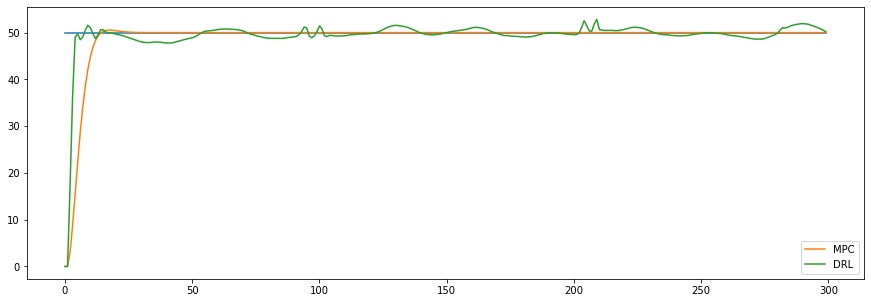

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:321.2962019862036
DRL:379.74719178484395


Critically Damped


100%|██████████| 300/300 [03:11<00:00,  1.56it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:47<00:00,  3.48s/it]


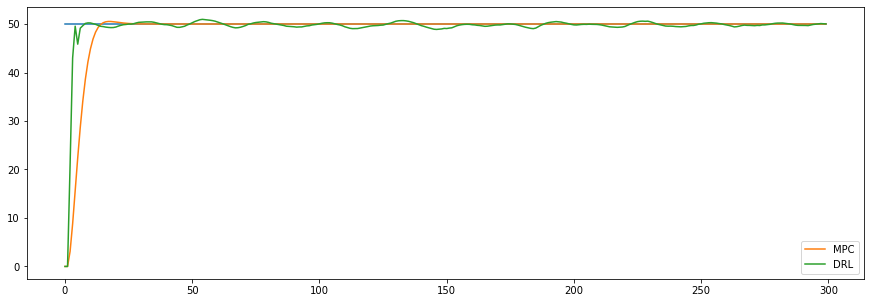

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:321.2962019862036
DRL:247.32329394964887


Underdamped


100%|██████████| 300/300 [03:12<00:00,  1.56it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:49<00:00,  3.49s/it]


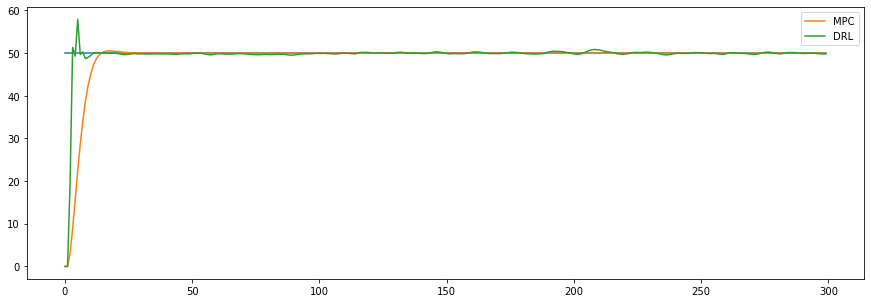

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:321.2962019862036
DRL:191.64356997339132


Overdamped


100%|██████████| 300/300 [03:23<00:00,  1.47it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:49<00:00,  3.50s/it]


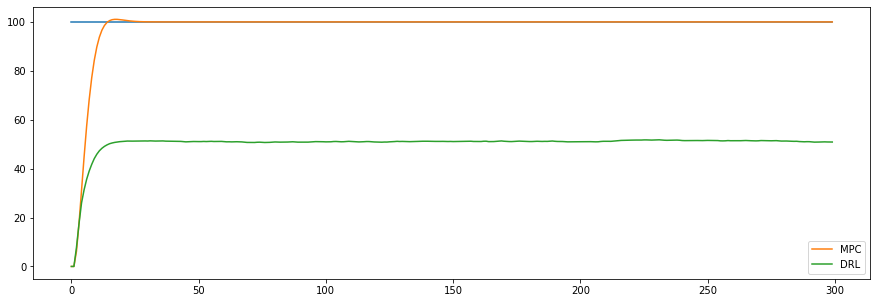

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:642.5793186015721
DRL:14936.338458201524


Critically Damped


100%|██████████| 300/300 [03:24<00:00,  1.47it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:50<00:00,  3.51s/it]


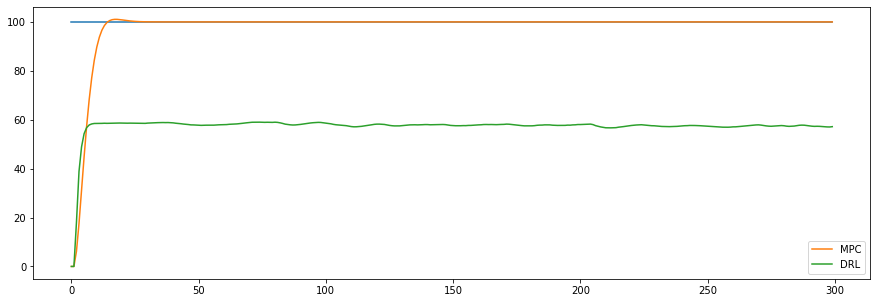

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:642.5793186015721
DRL:12825.361989290504


Underdamped


100%|██████████| 300/300 [03:25<00:00,  1.46it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:52<00:00,  3.52s/it]


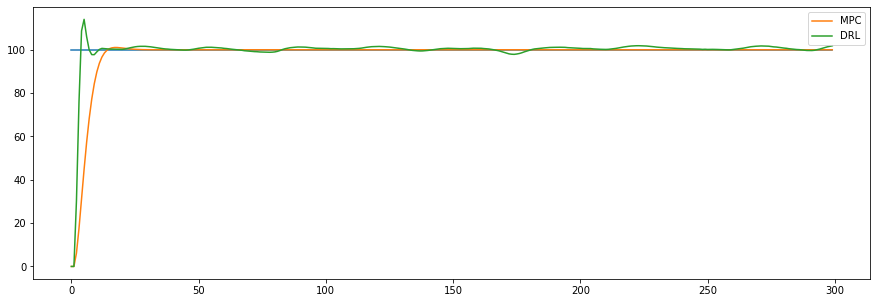

  1%|          | 2/300 [00:00<00:42,  6.95it/s]

MPC:642.5793186015721
DRL:546.2918221743561


Overdamped


100%|██████████| 300/300 [01:53<00:00,  2.65it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:51<00:00,  3.51s/it]


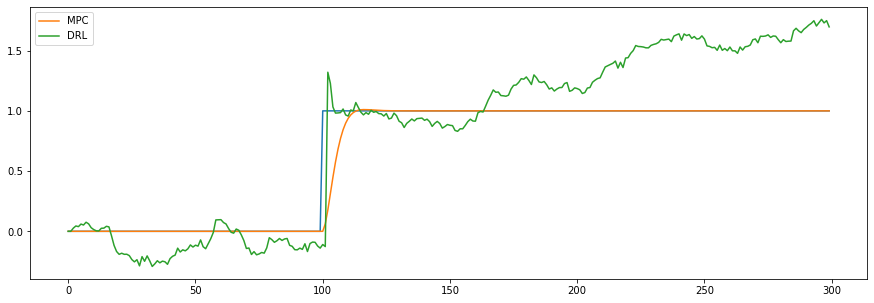

  0%|          | 1/300 [00:00<00:33,  9.01it/s]

MPC:5.433276428441345
DRL:79.18642858586955


Critically Damped


100%|██████████| 300/300 [01:52<00:00,  2.67it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:52<00:00,  3.52s/it]


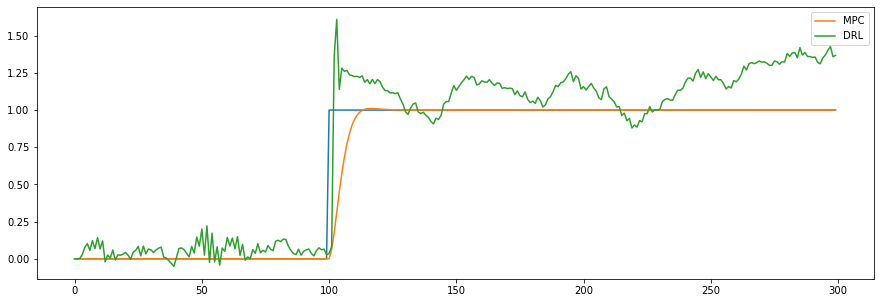

  1%|          | 2/300 [00:00<00:40,  7.40it/s]

MPC:5.433276428441345
DRL:42.963506880419125


Underdamped


100%|██████████| 300/300 [01:54<00:00,  2.61it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:53<00:00,  3.53s/it]


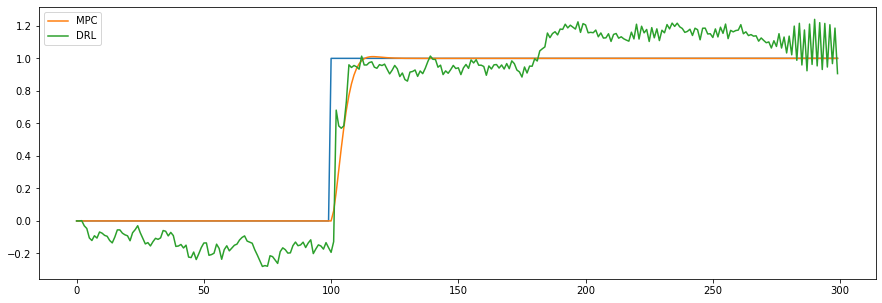

  1%|          | 2/300 [00:00<00:44,  6.72it/s]

MPC:5.433276428441345
DRL:39.69080395162824


Overdamped


100%|██████████| 300/300 [02:21<00:00,  2.13it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:54<00:00,  3.54s/it]


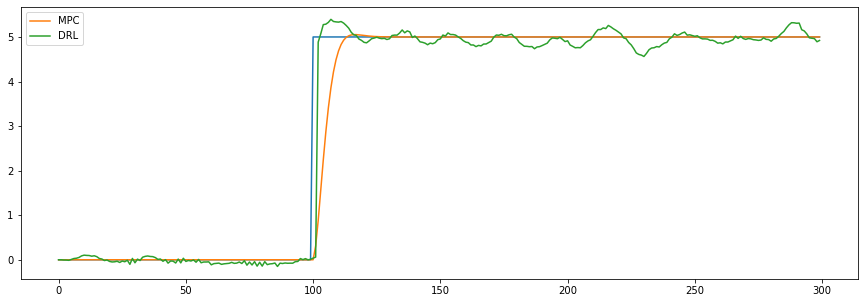

  0%|          | 1/300 [00:00<00:34,  8.60it/s]

MPC:27.13677104799015
DRL:39.85612789782482


Critically Damped


100%|██████████| 300/300 [02:21<00:00,  2.12it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:52<00:00,  3.52s/it]


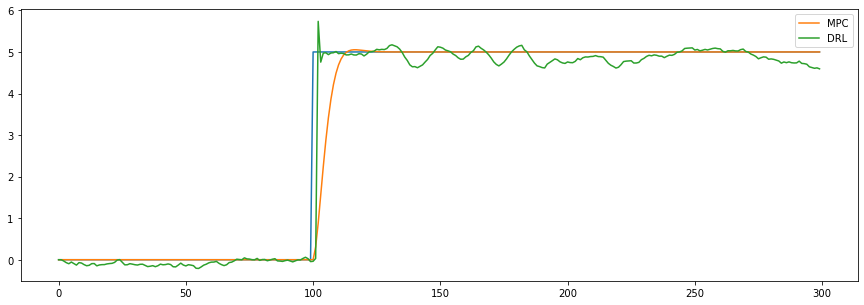

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:27.13677104799015
DRL:47.438836324200345


Underdamped


100%|██████████| 300/300 [02:21<00:00,  2.11it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:56<00:00,  3.56s/it]


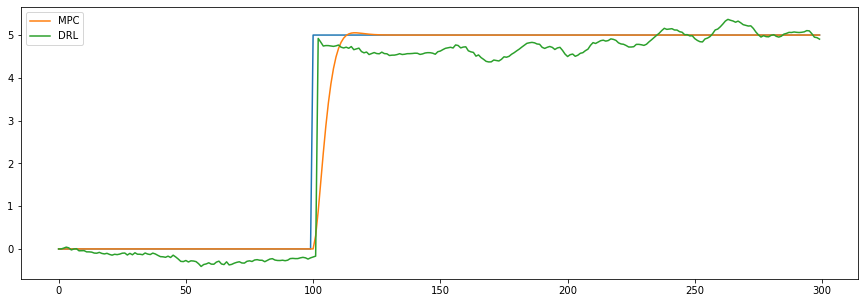

  1%|          | 2/300 [00:00<00:39,  7.58it/s]

MPC:27.13677104799015
DRL:82.59586775557881


Overdamped


100%|██████████| 300/300 [02:28<00:00,  2.02it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:56<00:00,  3.56s/it]


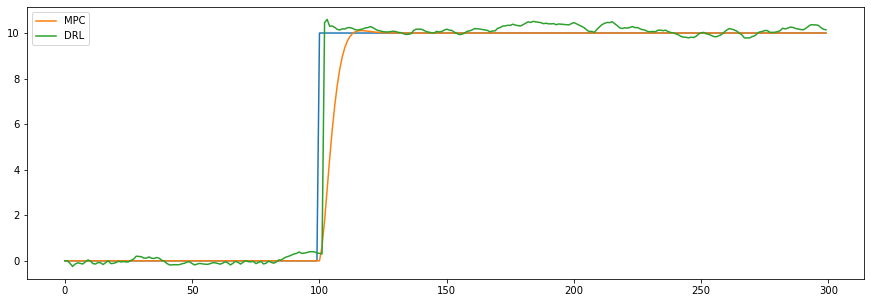

  0%|          | 1/300 [00:00<00:34,  8.59it/s]

MPC:54.26313548094265
DRL:69.88421069302532


Critically Damped


100%|██████████| 300/300 [02:28<00:00,  2.02it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:56<00:00,  3.57s/it]


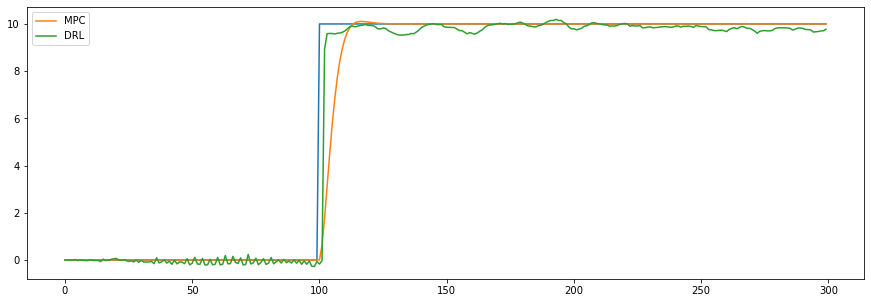

  1%|          | 2/300 [00:00<00:39,  7.55it/s]

MPC:54.26313548094265
DRL:64.47854351269172


Underdamped


100%|██████████| 300/300 [02:28<00:00,  2.02it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:57<00:00,  3.58s/it]


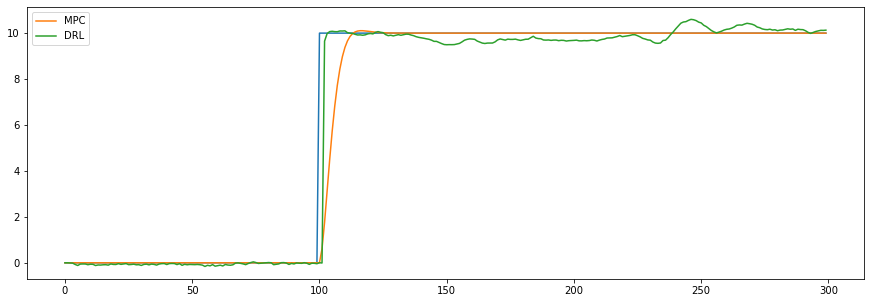

  1%|          | 2/300 [00:00<00:39,  7.60it/s]

MPC:54.26313548094265
DRL:72.46619760875633


Overdamped


100%|██████████| 300/300 [03:03<00:00,  1.63it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:59<00:00,  3.60s/it]


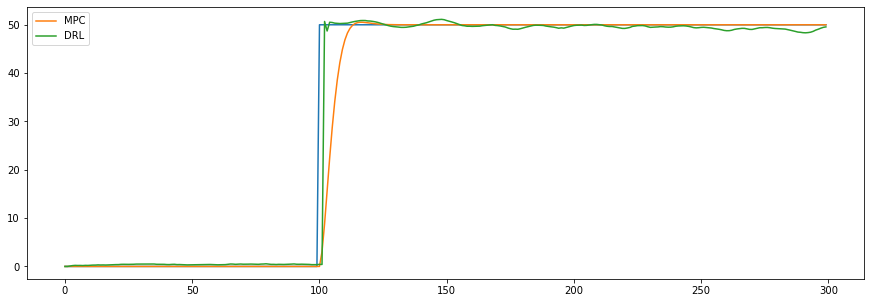

  1%|          | 2/300 [00:00<00:25, 11.47it/s]

MPC:271.2991056073408
DRL:247.29364126085756


Critically Damped


100%|██████████| 300/300 [03:03<00:00,  1.64it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [06:00<00:00,  3.60s/it]


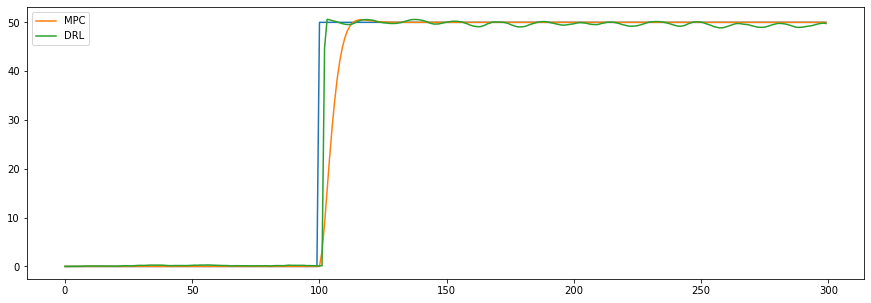

  1%|          | 2/300 [00:00<00:39,  7.57it/s]

MPC:271.2991056073408
DRL:199.50536229838997


Underdamped


100%|██████████| 300/300 [03:03<00:00,  1.64it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [06:01<00:00,  3.62s/it]


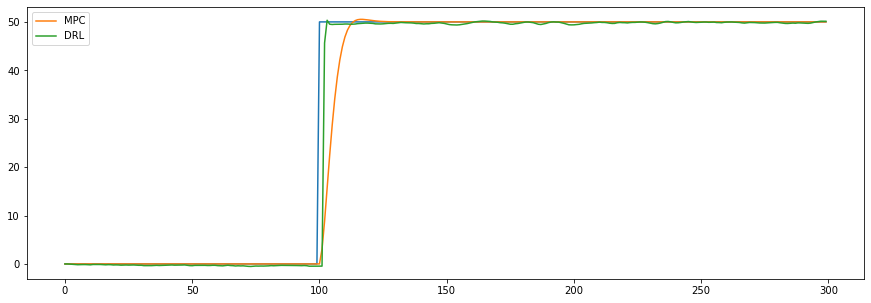

  0%|          | 1/300 [00:00<00:43,  6.87it/s]

MPC:271.2991056073408
DRL:180.41759319493116


Overdamped


100%|██████████| 300/300 [03:19<00:00,  1.50it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [05:58<00:00,  3.59s/it]


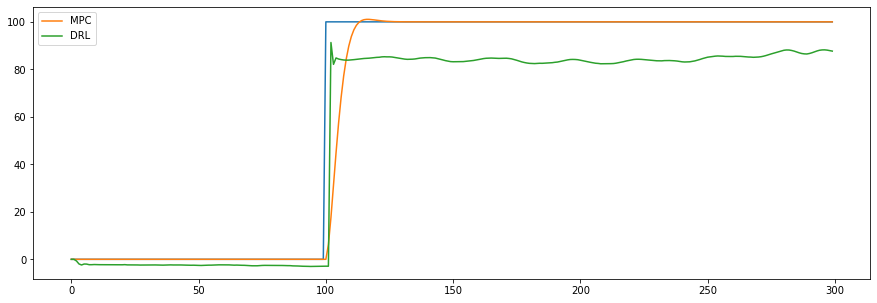

  1%|          | 2/300 [00:00<00:38,  7.66it/s]

MPC:542.5782955524246
DRL:3511.5187240480172


Critically Damped


100%|██████████| 300/300 [03:20<00:00,  1.49it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [06:04<00:00,  3.65s/it]


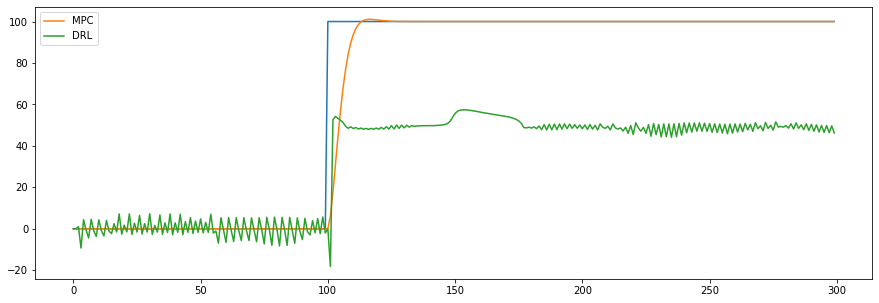

  1%|          | 2/300 [00:00<00:40,  7.27it/s]

MPC:542.5782955524246
DRL:10511.054015637696


Underdamped


100%|██████████| 300/300 [03:22<00:00,  1.48it/s]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [06:06<00:00,  3.67s/it]


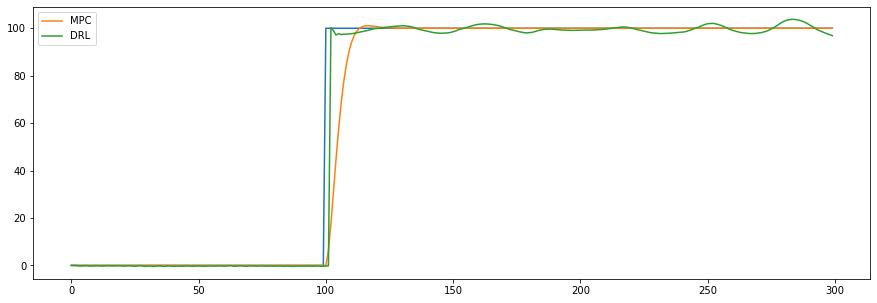

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:542.5782955524246
DRL:479.25009758275894


Overdamped


100%|██████████| 300/300 [08:30<00:00,  1.70s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [06:04<00:00,  3.64s/it]


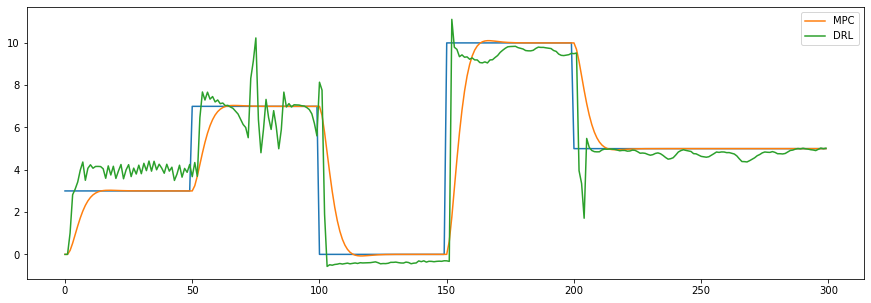

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:160.36531008712345
DRL:206.69666111441268


Critically Damped


100%|██████████| 300/300 [08:33<00:00,  1.71s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [06:07<00:00,  3.67s/it]


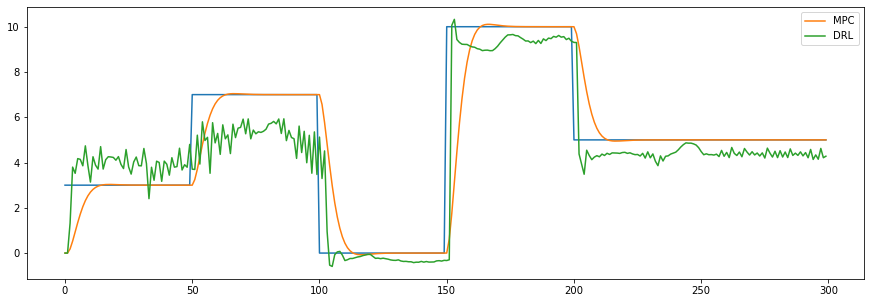

  0%|          | 0/300 [00:00<?, ?it/s]

MPC:160.36531008712345
DRL:296.66282348596985


Underdamped


100%|██████████| 300/300 [08:33<00:00,  1.71s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 100/100 [06:07<00:00,  3.67s/it]


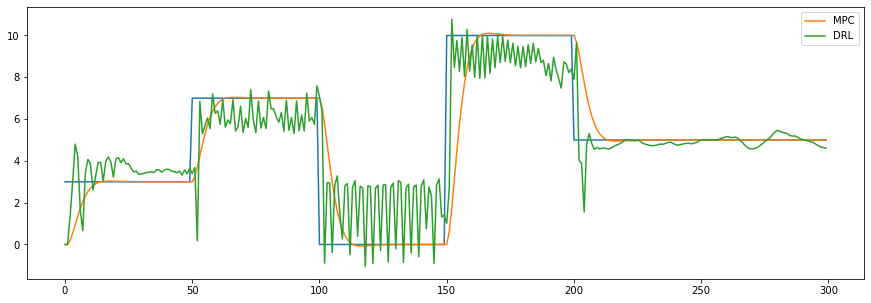

MPC:160.36531008712345
DRL:312.4518283547317




In [7]:
Setpoints = [[1]*300,[5]*300,[10]*300,[50]*300,[100]*300,[0]*100+[1]*200,[0]*100+[5]*200,[0]*100+[10]*200,[0]*100+[50]*200,[0]*100+[100]*200,[3]*50 + [7]*50 + [0]*50 + [10]*50 + [5]*100]

for i,setpoint in enumerate(Setpoints):
    Plots(setpoint, 3*i)